# HSG-12M

HSG-12M Spatial Multigraph Dataset.

This repository contains the code in the companion paper "HSG-12M: A Large-Scale Spatial Multigraph Dataset":
- downloading of the raw data files
- preliminary featurization and processing to PyTorch Geometric Dataset (both in memory and on disk)
- benchmarking on GNN baseline models
- generation of the HSG-12M
- deriving the six dataset variants, and generic custom subsets

The 1401 data files are publicly available at [Dataverse](https://doi.org/10.7910/DVN/PYDSSQ).

The dataset is generated by [`poly2graph`](https://github.com/sarinstein-yan/poly2graph).

In [22]:
import hsg
import os.path as osp
ROOT_DIR = '/mnt/ssd/nhsg12m'

## PyG Datasets

The download of raw data files is by `easyDataverse`, which sometimes encounters timeout connecting to Dataverse. Retry or connect to better network if you encounter timeout when initializing the dataset.

The NetworkX MultiGraph dataset is processed to PyTorch Geometric Dataset via the scheme discussed in the companion paper. 

Feel free to overwrite the `process` method in `HSGOnDisk` or `HSGInMemory` to customize the featurization and processing.

In [24]:
from hsg import HSGOnDisk, HSGInMemory

# # use HSGOnDisk if some large dataset variant overflows RAM
# ds = HSGOnDisk(root=ROOT_DIR, subset="one-band")

ds = HSGInMemory(root=ROOT_DIR, subset="one-band")

In [27]:
print("Number of graphs:", len(ds))
print("Number of classes:", ds.num_classes)
print("Number of node features:", ds.num_features)
print("Number of edge features:", ds.num_edge_features)
print("A graph:", ds[12345])

Number of graphs: 198744
Number of classes: 24
Number of node features: 4
Number of edge features: 13
A graph: Data(edge_index=[2, 6], x=[4, 4], edge_attr=[6, 13], y=[1])


## Benchmarking

The train / test / validation split, training, evaluation, and logging are handled by `PyTorch Lightning`

In [28]:
from hsg import HSGLitDataModule

dm = HSGLitDataModule(root=ROOT_DIR, subset="one-band", seeds=[42], batch_size=256)
dm.prepare_data()
dm.setup()

print("Batches in train loader:", len(dm.train_dataloader()))
print("Batches in val loader:", len(dm.val_dataloader()))
print("Batches in test loader:", len(dm.test_dataloader()))

Batches in train loader: 622
Batches in val loader: 78
Batches in test loader: 78


In [ ]:
from argparse import Namespace

args = Namespace(
    root=ROOT_DIR,
    save_dir=ROOT_DIR+'/baseline_result',
    subset='one-band',
    # ^ available: one-band, two-band, three-band, topology, all (all-static)
    models=['gcn', 'sage', 'gat', 'gin'],
    # ^ available: gcn, sage, gat, gatv2, gin, gine; omit for all
    epochs=1,
    batch_size=256,
    dim_gnn=256,
    dim_mlp=256,
    layers_gnn=4,
    layers_mlp=2,
    heads=1,
    # ^ only for GAT and GATv2
    dropout=0.1,
    lr_init=1e-2,
    lr_min=1e-5,
    t0=10,
    t_mult=4,
    seeds=[42, 624, 706],
    log_every_n_steps=5,
    early_stop_patience=10,
)

hsg.run_experiment(args)

## Raw Data Files

The download of raw data files is by `easyDataverse`, which sometimes encounters timeout connecting to Dataverse. Retry or connect to better network if you encounter timeout when initializing the dataset.

In [ ]:
from easyDataverse import Dataverse

server_url = "https://dataverse.harvard.edu"
dataset_pid = "doi:10.7910/DVN/PYDSSQ"

dv = Dataverse(server_url)
hsg12m = dv.load_dataset(
    pid=dataset_pid, 
    # local directory to save files
    filedir=ROOT_DIR,
    # which classes to download
    filenames=[f'raw/class_{i}.npz' for i in range(1401)],
    # Set to True to download the files, requires at least 257GB of free space
    download_files=False,
)

# metadata
print(hsg12m.citation)

### Content of each file
Each file stores spectral graph data generated from one **polynomial class**. These files are created by the `hsg.HSG_Generator.generate_dataset(...)` method and are named as: `class_{class_index}.npz`. (See [HSG-12M generation](tutorial.ipynb#hsg-12m-generation) )

| Key             | Type            | Meaning |
|------------------|------------------|---------|
| `graphs_pickle` | `List[bytes]`    | List of **serialized NetworkX MultiGraph objects**, each corresponding to a `(a, b)` parameter pair. |
| `y`             | `int`            | Class label. | 
| `a_vals`        | `np.ndarray`     | List of parameter values for `a` used. |
| `b_vals`        | `np.ndarray`     | List of parameter values for `b` used. |
| `class_meta`    | `Dict[str, Any]` | Class-level metadata, including polynomial class and Hamiltonian information. |

**Note:** Except for `y` and `class_meta` which are class-level, the other three are **aligned by index**, i.e., the $i$-th graph in `graphs_pickle` was generated using `a = a_vals[i]` and `b = b_vals[i]`.

### Content of `class_meta`

| Key | Type | Meaning |
|-----|------|---------|
| `parameter_symbols` | `Tuple[str, …]` | Symbols of the free coefficients inserted into the polynomial (e.g. `('a', 'b')`). |
| `latex` | `str` | LaTeX code for the fully-expanded polynomial. |
| `sympy_repr` | `str` | sympy standard representation of the polynomial. |
| `generator_symbols` | `Tuple[str, …]` | The `sympy.Poly`'s generator — normally `('z', '1/z', 'E')`. |
| `number_of_bands` | `int` | Number of bands $b$ (= highest exponent of `E` of the base term `-E**b`). |
| `max_left_hopping` | `int` | The highest exponent of $z$, i.e. $q$ of the base term `z**q`. |
| `max_right_hopping` | `int` | The lowest exponent of $z$, i.e. $p = D - q$ of the base term `z**(-p)`. |
| `intermediate_z_degrees` | `Tuple[int, …]` | All non-zero $z$-exponents that lie **between** `-p` and `q` (excluding end-caps). |
| `E_deg_assignments` | `Tuple[int, …]` | For each intermediate exponent, the power of `E`. |
| `param_degree_placements` | `Tuple[int, …]` | Subset of `intermediate_z_degrees` that host *parameter symbols* instead of unit coefficients. |

<br>

Take the **9-th** class as an example, if the `raw/class_9.npz` file is downloaded, one can load the `nx.MultiGraph` objects, class label `y`, the parameter values `a_vals`, `b_vals`, and the class-specific metadata as follows:

In [29]:
nx_graphs, y, a_vals, b_vals, class_meta = hsg.load_class(class_idx=9, raw_dir=osp.join(ROOT_DIR,'raw'))

print("class label:", y)
print("a_vals:", a_vals)
print("b_vals:", b_vals)
print("polynomial latex:", class_meta['latex'])
print("polynomial parameter symbols:", class_meta['parameter_symbols'])
print("polynomial generators:", class_meta['generator_symbols'])
print("number of bands:", class_meta['number_of_bands'])
print("max left hopping:", class_meta['max_left_hopping'])
print("max right hopping:", class_meta['max_right_hopping'])

import sympy as sp
poly = sp.sympify(class_meta['sympy_repr'])
poly

class label: 9
a_vals: [-10.-5.j -10.-2.j -10.-1.j ...  10.+1.j  10.+2.j  10.+5.j]
b_vals: [-10.-5.j -10.-5.j -10.-5.j ...  10.+5.j  10.+5.j  10.+5.j]
polynomial latex: - E + \frac{a}{z} + b z + z^{2} + \frac{1}{z^{2}}
polynomial parameter symbols: ['a' 'b']
polynomial generators: ['z' '1/z' 'E']
number of bands: 1
max left hopping: 2
max right hopping: 2


Poly(z**2 + b*z + (1/z)**2 + a*(1/z) - E, z, 1/z, E, domain='ZZ[a,b]')

### Node and Edge Attributes of the Spectral Graph Object

Each spectral graph is represented as a `networkx.MultiGraph` object.

---

#### Node Attributes

| Attribute | Type              | Description |
|-----------|-------------------|-------------|
| `pos`     | `(2,) np.ndarray` | 2D position of the node in the complex energy plane $(\text{Re}(E), \text{Im}(E))$. |
| `dos`     | `float`           | **Density of States** at the node, the number of eigenvalues per unit area. |
| `potential` | `float`         | **Spectral Potential** at the node, i.e. Ronkin function, an algebro-geometric property of the characteristic polynomial.  |

---

#### Edge Attributes

| Attribute | Type                | Description |
|-----------|---------------------|-------------|
| `weight`  | `float`             | Length of the edge in the complex energy plane. |
| `pts`     | `(w, 2) np.ndarray` | Discretized points along the edge, forming a path in the complex plane. `w` is the number of samples along the edge. |
| `avg_dos` | `float`             | Average density of states sampled along the edge. |
| `avg_potential` | `float`       | Average spectral potential sampled along the edge. |

Take the $1234$-th graph in the `class_9.npz` file as an example:

a = (0.1-1j), b = (-5+5j)

    Nodes: [(0, {'pos': array([-7.85831195,  5.63079328]), 'dos': np.float32(0.25101075), 'potential': np.float32(-1.7545433)}), (3, {'pos': array([6.69559824, 3.57594968]), 'dos': np.float32(0.23724917), 'potential': np.float32(-1.6002026)}), (6, {'pos': array([1.56957655, 0.94456724]), 'dos': np.float32(0.085914895), 'potential': np.float32(-1.2916195)}), (7, {'pos': array([ 1.20739188, -3.80079098]), 'dos': np.float32(0.23262492), 'potential': np.float32(-1.4785695)})]

    Edges: [(0, 6, {'weight': np.float64(11.322210064669378), 'pts': array([[-7.81765857,  5.61601023],
       [-7.80287552,  5.61601023],
       [-7.78809248,  5.61601023],
       ...,
       [ 1.54001045,  0.95935029],
       [ 1.5547935 ,  0.95935029],
       [ 1.56957655,  0.94456724]], shape=(636, 2)), 'avg_dos': np.float32(0.07713379), 'avg_potential': np.float32(-1.5248148)}), (3, 6, {'weight': np.float64(6.169199202476567), 'pts': array([[6.65494486, 3.56116664],
       [6.64016181,

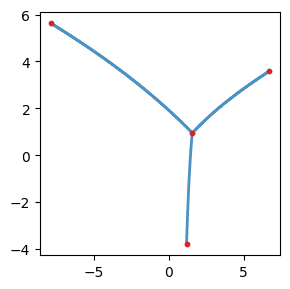

In [30]:
import numpy as np
import networkx as nx

gid = 1234
graph = nx_graphs[gid]

np.set_printoptions(threshold=20, edgeitems=3)
print(f"a = {a_vals[gid]}, b = {b_vals[gid]}\n")
print(f"    Nodes: {graph.nodes(data=True)}\n")
print(f"    Edges: {graph.edges(data=True)}\n")
print(f"    Class meta data: {class_meta}")


import matplotlib.pyplot as plt

def plot_spatial_multigraph(graph, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for es, ee, pts in graph.edges(data='pts'):
        ax.plot(*pts.T, c='tab:blue', lw=2, alpha=0.8)
    for n, (x, y) in graph.nodes(data='pos'):
        ax.scatter(x, y, c='tab:red', s=10, zorder=10)
    return ax

fig, ax = plt.subplots(figsize=(3, 3))
plot_spatial_multigraph(graph, ax=ax)
plt.tight_layout()
plt.show()

## HSG-12M Generation

The dataset generator used in the companion paper is as follows:

In [ ]:
gen = hsg.HSG_Generator(
    root=ROOT_DIR,
    hopping_range=[4,5,6], 
    num_bands=[1,2,3],
    real_coeff_walk=[-10, -5, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 5, 10],
    imag_coeff_walk=[-5, -2, -1, 0, 1, 2, 5],
)
num_classes = len(gen.all_metas)

Run the following cell to generate the 1401 raw data files of HSG-12M (saved to `HSG_Generator.root_dir + '/raw'`):

In [ ]:
# for i in range(num_classes):
#     gen.generate_dataset(
#             class_idx=i,
#             num_partition=20,
#             # ^ generate the class in 20 partitions, can set to 1 if RAM is large enough
#             short_edge_threshold=30,
#             # ^ merge near-by nodes within this distance threshold, see `poly2graph` documentation
#         )

## Load `T-HSG-5.1M`

Again, take the **9-th** class as an example, to obtain the temporal graphs derived from class 9 (ensure the `class_9.npz` file is in the `gen.root_dir/raw` directory):

In [32]:
tg_9 = gen.get_temporal_graphs_by_class(class_idx=9)
print("Number of temporal graphs in class 9:", len(tg_9))

Number of temporal graphs in class 9: 3640


To get the whole `T-HSG-5.1M` as a `List[List[networkx.MultiGraph]]` (ensure all 1401 files are downloaded or generated at `gen.root_dir/raw`):

In [ ]:
thsg = []
y = []
from tqdm import tqdm
for i in tqdm(range(num_classes)):
    tg_i = gen.get_temporal_graphs_by_class(i)
    thsg.extend(tg_i)
    y.extend([i] * len(tg_i))

print("Number of temporal graphs:", len(thsg))